In [2]:
import numpy as np
import requests
from bs4 import BeautifulSoup
import time
import re
import pandas as pd
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from datetime import datetime
from sentence_transformers import SentenceTransformer, util
from nltk.tokenize import sent_tokenize
import torch
import nltk

In [2]:
data = pd.read_csv(r'C:\Users\boyu571\boyu571_Github\01_Kakaobank_SKKU_Research_23\data\foreign_news_data\first_processed_eng_data.csv')
data

,source,author,title,description,url,urlToImage,time,content,press,content_full,date
0,"{'id': 'australian-financial-review', 'name': ...","Ben Potter, AFR.com",This Australian startup will offer shares in l...,Perth-based BitCar is seeking more than $US20 ...,https://www.afr.com/news/bitcar-ico-seeks-25m-...,https://edge.alluremedia.com.au/uploads/busine...,2017-11-09 11:44:01+00:00,Perth-based BitCar is seeking more than $US20 ...,Australian Financial Review,Perth-based BitCar is seeking more than $US20 ...,2017-11-09
1,"{'id': None, 'name': 'Gizmodo Australia'}",Gizmodo Australia,Deals: Learn How To Buy And Sell Bitcoin For 9...,Bitcoin and other cryptocurrencies have floate...,https://www.gizmodo.com.au/2017/11/deals-learn...,https://edge.alluremedia.com.au/m/g/2016/12/iS...,2017-11-09 13:45:42+00:00,Bitcoin and other cryptocurrencies have floate...,Gizmodo Australia,Bitcoin and other cryptocurrencies have floate...,2017-11-09
2,"{'id': None, 'name': 'Yahoo Entertainment'}",NaN,Bitcoin price is dependent on maintaining a sh...,Former Federal Reserve Chairman Alan Greenspan...,https://finance.yahoo.com/video/bitcoin-price-...,https://s.yimg.com/uu/api/res/1.2/EI4AFtNzs8SG...,2017-11-09 15:58:00+00:00,Lori: I seriously cannot believe how low peopl...,Yahoo Entertainment,Former Federal Reserve Chairman Alan Greenspan...,2017-11-09
3,"{'id': 'breitbart-news', 'name': 'Breitbart Ne...",Ezra Dulis,"Bitcoin Surges, Then Sags After Investors Lose...","The price of Bitcoin surged to nearly $8,000 p...",http://www.breitbart.com/tech/2017/11/09/bitco...,http://media.breitbart.com/media/2017/11/10867...,2017-11-09 18:32:29+00:00,"If you have no idea what any of that means, he...",Breitbart News,"The price of Bitcoin surged to nearly $8,000 p...",2017-11-09
4,"{'id': None, 'name': 'Yahoo Entertainment'}",NaN,Mark Cuban: Here's the best way to invest your...,Investing great Warren Buffett agrees with Cub...,https://finance.yahoo.com/news/mark-cuban-apos...,https://s.yimg.com/uu/api/res/1.2/zPT4W4Ze4339...,2017-11-09 18:40:09+00:00,You hear it all the time: Put your money to wo...,Yahoo Entertainment,You hear it all the time: Put your money to wo...,2017-11-09
...,...,...,...,...,...,...,...,...,...,...,...
341782,"{'id': None, 'name': 'ZyCrypto'}",Newton Gitonga,CFTC Charges Three Defi Projects for Illegal O...,The Commodity Futures Trading Commission (CFTC...,https://zycrypto.com/cftc-charges-three-defi-p...,https://zycrypto.com/wp-content/uploads/2021/1...,2023-09-30 21:08:56+00:00,The Commodity Futures Trading Commission (CFTC...,ZyCrypto,The Commodity Futures Trading Commission (CFTC...,2023-09-30
341783,"{'id': None, 'name': 'Investing.com'}",Cointelegraph,"Ether futures ETFs launching, SBF trial to beg...","Ether futures ETFs launching, SBF trial to beg...",https://www.investing.com/news/cryptocurrency-...,https://i-invdn-com.investing.com/news/Cryptoc...,2023-09-30 21:20:17+00:00,Investment firm Valkyrie will start offering e...,Investing.com,"Ether futures ETFs launching, SBF trial to beg...",2023-09-30
341784,"{'id': None, 'name': 'ZyCrypto'}",Newton Gitonga,XRP Lawsuit: John Deaton Concurs “The SEC Harm...,"John Deaton, a prominent pro-Ripple lawyer rep...",https://zycrypto.com/xrp-lawsuit-john-deaton-c...,https://zycrypto.com/wp-content/uploads/2023/0...,2023-09-30 21:23:16+00:00,"John Deaton, a prominent pro-Ripple lawyer rep...",ZyCrypto,"John Deaton, a prominent pro-Ripple lawyer rep...",2023-09-30
341785,"{'id': None, 'name': 'Investing.com'}",U.Today,Shiba Inu (SHIB) Negatively Correlates With Bi...,Shiba Inu (SHIB) Negatively Correlates With Bi...,https://www.investing.com/news/cryptocurrency-...,https://i-invdn-com.investing.com/news/LYNXNPE...,2023-09-30 22:00:22+00:00,U.Today - Dog-themed cryptocurrency is seeing ...,Investing.com,Shiba Inu (SHIB) Negatively Correlates With Bi...,2023-09-30


In [3]:
# Define the date range and specific date to filter
start_date = '2023-07-28'
end_date = '2023-09-30'

# Convert the 'date' column to datetime if it is not already
data['date'] = pd.to_datetime(data['date'])

# Create the subset_data DataFrame by filtering the date range and specific date
subset_data = data[
    (data['date'] >= start_date) &
    (data['date'] <= end_date)
]

subset_data

# test_data = data[data['date'].str.startswith('2017-11')]
# test_data

,source,author,title,description,url,urlToImage,time,content,press,content_full,date
328594,"{'id': None, 'name': 'The Daily Hodl'}",Daily Hodl Staff,Ethereum-Based Altcoin That’s Up Over 37% This...,Blockchain analytics platform Santiment says t...,https://dailyhodl.com/2023/07/27/ethereum-base...,https://dailyhodl.com/wp-content/uploads/2023/...,2023-07-28 00:00:45+00:00,Blockchain analytics platform Santiment says t...,The Daily Hodl,Blockchain analytics platform Santiment says t...,2023-07-28
328595,"{'id': None, 'name': 'Bitcoinist'}",Dalmas Ngetich,CME Group: Ethereum To Outperform Bitcoin Afte...,"The Chicago Mercantile Exchange (CME) Group, w...",https://bitcoinist.com/cme-group-ethereum-bitc...,https://bitcoinist.com/wp-content/uploads/2023...,2023-07-28 00:00:56+00:00,"The Chicago Mercantile Exchange (CME) Group, w...",Bitcoinist,"The Chicago Mercantile Exchange (CME) Group, w...",2023-07-28
328596,"{'id': None, 'name': 'Activistpost.com'}",Activist Post,"The CBDCs Are Coming, And The Elite Plan To Us...",By Michael Snyder Central bank digital currenc...,https://www.activistpost.com/2023/07/the-cbdcs...,https://www.activistpost.com/wp-content/upload...,2023-07-28 00:12:38+00:00,By Michael Snyder\r\nCentral bank digital curr...,Activistpost.com,By Michael Snyder Central bank digital currenc...,2023-07-28
328597,"{'id': None, 'name': 'Activistpost.com'}",Activist Post,Maryland Supreme Court: Police Can’t Search Di...,By Andrew Crocker This post was co-authored by...,https://www.activistpost.com/?p=256719,NaN,2023-07-28 00:19:46+00:00,By Andrew Crocker\r\nThis post was co-authored...,Activistpost.com,By Andrew Crocker This post was co-authored by...,2023-07-28
328598,"{'id': None, 'name': 'Activistpost.com'}",Activist Post,"As Unvaxxed Man Denied Organ Transplant Dies, ...",By Mike Campbell After being denied an organ t...,https://www.activistpost.com/2023/07/as-unvaxx...,https://www.activistpost.com/wp-content/upload...,2023-07-28 00:28:10+00:00,By Mike Campbell\r\nAfter being denied an orga...,Activistpost.com,By Mike Campbell After being denied an organ t...,2023-07-28
...,...,...,...,...,...,...,...,...,...,...,...
341782,"{'id': None, 'name': 'ZyCrypto'}",Newton Gitonga,CFTC Charges Three Defi Projects for Illegal O...,The Commodity Futures Trading Commission (CFTC...,https://zycrypto.com/cftc-charges-three-defi-p...,https://zycrypto.com/wp-content/uploads/2021/1...,2023-09-30 21:08:56+00:00,The Commodity Futures Trading Commission (CFTC...,ZyCrypto,The Commodity Futures Trading Commission (CFTC...,2023-09-30
341783,"{'id': None, 'name': 'Investing.com'}",Cointelegraph,"Ether futures ETFs launching, SBF trial to beg...","Ether futures ETFs launching, SBF trial to beg...",https://www.investing.com/news/cryptocurrency-...,https://i-invdn-com.investing.com/news/Cryptoc...,2023-09-30 21:20:17+00:00,Investment firm Valkyrie will start offering e...,Investing.com,"Ether futures ETFs launching, SBF trial to beg...",2023-09-30
341784,"{'id': None, 'name': 'ZyCrypto'}",Newton Gitonga,XRP Lawsuit: John Deaton Concurs “The SEC Harm...,"John Deaton, a prominent pro-Ripple lawyer rep...",https://zycrypto.com/xrp-lawsuit-john-deaton-c...,https://zycrypto.com/wp-content/uploads/2023/0...,2023-09-30 21:23:16+00:00,"John Deaton, a prominent pro-Ripple lawyer rep...",ZyCrypto,"John Deaton, a prominent pro-Ripple lawyer rep...",2023-09-30
341785,"{'id': None, 'name': 'Investing.com'}",U.Today,Shiba Inu (SHIB) Negatively Correlates With Bi...,Shiba Inu (SHIB) Negatively Correlates With Bi...,https://www.investing.com/news/cryptocurrency-...,https://i-invdn-com.investing.com/news/LYNXNPE...,2023-09-30 22:00:22+00:00,U.Today - Dog-themed cryptocurrency is seeing ...,Investing.com,Shiba Inu (SHIB) Negatively Correlates With Bi...,2023-09-30


In [4]:
# sBERT 모델 로드
model = SentenceTransformer('paraphrase-distilroberta-base-v1')

# 코사인 유사도 계산 함수
def cosine_similarity(embedding1, embedding2):
    return util.pytorch_cos_sim(embedding1, embedding2)

# 문서 임베딩 생성 함수
# def create_document_embeddings(sentences):
#     sentence_embeddings = model.encode(sentences, convert_to_tensor=True)
#     document_embedding = torch.mean(sentence_embeddings, dim=0)
#     return document_embedding

def create_document_embeddings(sentences):
    if not sentences:  # Check if the list of sentences is empty
        return None  # Return None if there are no sentences to encode
    try:
        sentence_embeddings = model.encode(sentences, convert_to_tensor=True)
        document_embedding = torch.mean(sentence_embeddings, dim=0)
        return document_embedding
    except Exception as e:
        print(f"Error in create_document_embeddings: {e}")
        print(f"Sentences: {sentences}")
        return None  # Return None in case of any other error


def cluster_and_filter_articles(group):
    filtered_group = pd.DataFrame()
    try:
        document_embeddings = []
        for content in group['content_full']:
            embedding = create_document_embeddings(sent_tokenize(content))
            if embedding is not None:
                document_embeddings.append(embedding)
        
        if not document_embeddings:
            return filtered_group  # If no embeddings, return empty DataFrame

        similarity_matrix = compute_similarity_matrix(document_embeddings)
        clusters = []
        visited = np.zeros(len(document_embeddings), dtype=bool)

        for i in range(len(document_embeddings)):
            if not visited[i]:
                similar_articles = np.where(np.array(similarity_matrix[i]) > 0.6)[0]
                clusters.append(similar_articles)
                visited[similar_articles] = True

        representative_indices = [cluster[0] for cluster in clusters if len(cluster) > 0]
        if representative_indices:
            filtered_group = group.iloc[representative_indices].reset_index(drop=True)
    except Exception as e:
        print(f"Error in cluster_and_filter_articles: {e}")
    
    return filtered_group

# 유사도 행렬 계산 함수
def compute_similarity_matrix(document_embeddings):
    similarity_matrix = []
    for embedding1 in document_embeddings:
        row = []
        for embedding2 in document_embeddings:
            similarity = cosine_similarity(embedding1, embedding2).item()
            row.append(similarity)
        similarity_matrix.append(row)
    return similarity_matrix

In [5]:
grouped_data = subset_data.groupby('date')
filtered_data = pd.DataFrame()

for date, group in grouped_data:
    try:
        filtered_group = cluster_and_filter_articles(group)
        if not filtered_group.empty:
            filtered_data = pd.concat([filtered_data, filtered_group], ignore_index=True)
    except Exception as e:
        print(f"Error at date {date}: {e}")

print(filtered_data)

                                        source             author  \
0       {'id': None, 'name': 'The Daily Hodl'}   Daily Hodl Staff   
1           {'id': None, 'name': 'Bitcoinist'}     Dalmas Ngetich   
2     {'id': None, 'name': 'Activistpost.com'}      Activist Post   
3           {'id': None, 'name': 'Bitcoinist'}     Dalmas Ngetich   
4     {'id': None, 'name': 'Activistpost.com'}      Activist Post   
...                                        ...                ...   
3373        {'id': None, 'name': 'Bitcoinist'}           Yuna Rin   
3374           {'id': None, 'name': 'newsBTC'}           predycto   
3375           {'id': None, 'name': 'Decrypt'}      Liam J. Kelly   
3376           {'id': None, 'name': 'Decrypt'}  Jose Antonio Lanz   
3377   {'id': None, 'name': 'Coinjournal.net'}       Mircea Vasiu   

                                                  title  \
0     Ethereum-Based Altcoin That’s Up Over 37% This...   
1     CME Group: Ethereum To Outperform Bitcoin Afte.

In [8]:
filtered_data

,source,author,title,description,url,urlToImage,time,content,press,content_full,date
0,"{'id': None, 'name': 'Activistpost.com'}",Activist Post,Got Google Smart Home Speakers? Researcher Rev...,"By B.N. Frank Over the years, countless expert...",https://www.activistpost.com/2022/12/got-googl...,https://www.activistpost.com/wp-content/upload...,2023-01-01 00:02:08+00:00,"By B.N. Frank\r\nOver the years, countless exp...",Activistpost.com,"By B.N. Frank Over the years, countless expert...",2023-01-01
1,"{'id': None, 'name': 'U.Today'}",U.Today,Satoshi Nakamoto: Here Are Top News Related to...,U.Today wrapped up the hottest news about Bitc...,https://u.today/satoshi-nakamoto-here-are-top-...,https://u.today/sites/default/files/styles/twi...,2023-01-01 01:00:00+00:00,The true identity of enigmatic Bitcoin creator...,U.Today,The true identity of enigmatic Bitcoin creator...,2023-01-01
2,"{'id': None, 'name': 'Independent.ie'}",Gabrielle Monaghan,‘You can lose a lot of money’ – Watchdog to ta...,Consumer watchdog The Competition and Consumer...,https://www.independent.ie/business/irish/you-...,https://www.independent.ie/business/irish/41fa...,2023-01-01 02:30:00+00:00,Consumer watchdog The Competition and Consumer...,Independent.ie,Consumer watchdog The Competition and Consumer...,2023-01-01
3,"{'id': None, 'name': 'Ambcrypto.com'}",Suzuki Shillsalot,Cardano [ADA]: Risk-averse traders can lock ga...,Disclaimer: The information presented does not...,https://ambcrypto.com/cardano-ada-risk-averse-...,https://ambcrypto.com/wp-content/uploads/2022/...,2023-01-01 03:30:26+00:00,Disclaimer: The information presented does not...,Ambcrypto.com,Disclaimer: The information presented does not...,2023-01-01
4,"{'id': None, 'name': 'CryptoGlobe'}",Guest Contributor,Does Binance Have Deposit Limits?,Binance is one of the most popular cryptocurre...,https://www.cryptoglobe.com/latest/2023/01/bin...,https://cryptoglobe.s3.eu-west-2.amazonaws.com...,2023-01-01 03:31:00+00:00,Binance is one of the most popular cryptocurre...,CryptoGlobe,Binance is one of the most popular cryptocurre...,2023-01-01
...,...,...,...,...,...,...,...,...,...,...,...
12199,"{'id': None, 'name': 'Cointelegraph'}",Cointelegraph By Brayden Lindrea,Redditor's hacked Bitcoin is a lesson on the h...,Blockchain security firm CertiK warns crypto h...,https://cointelegraph.com/news/redditor-gets-l...,https://images.cointelegraph.com/images/1200_a...,2023-07-27 04:08:19+00:00,A Reddit user has become the latest example of...,Cointelegraph,A Reddit user has become the latest example of...,2023-07-27 00:00:00
12200,"{'id': None, 'name': 'The Daily Hodl'}",Daily Hodl Staff,One Catalyst Could Trigger Bitcoin To Explode ...,Fundstrat Global Advisors’ managing partner To...,https://dailyhodl.com/2023/07/27/one-catalyst-...,https://dailyhodl.com/wp-content/uploads/2023/...,2023-07-27 07:04:40+00:00,Fundstrat Global Advisors managing partner Tom...,The Daily Hodl,Fundstrat Global Advisors’ managing partner To...,2023-07-27 00:00:00
12201,"{'id': None, 'name': 'Cointelegraph'}",Cointelegraph By Tom Mitchelhill,Robert Kennedy Jr. admits to buying 2 Bitcoin ...,Democratic presidential hopeful Robert F. Kenn...,https://cointelegraph.com/news/presidential-ca...,https://images.cointelegraph.com/images/1200_a...,2023-07-27 03:13:58+00:00,Democratic presidential candidate Robert F. Ke...,Cointelegraph,Democratic presidential candidate Robert F. Ke...,2023-07-27 00:00:00
12202,"{'id': None, 'name': 'MarketWatch'}",Jon Swartz,: Sequoia Capital hacks crypto fund as part of...,Storied venture-capital firm Sequoia Capital h...,https://www.marketwatch.com/story/sequoia-capi...,https://s.wsj.net/public/resources/MWimages/MW...,2023-07-27 21:11:00+00:00,Storied venture-capital firm Sequoia Capital h...,MarketWatch,Storied venture-capital firm Sequoia Capital h...,2023-07-27 00:00:00


In [19]:
mid_data.to_csv('eng_ver1_part2.csv', encoding='utf-8-sig', index=False)

In [7]:
part2_data = pd.read_csv('eng_ver1_part2.csv')
part2_data

,source,author,title,description,url,urlToImage,time,content,press,content_full,date
0,"{'id': None, 'name': 'Activistpost.com'}",Activist Post,Got Google Smart Home Speakers? Researcher Rev...,"By B.N. Frank Over the years, countless expert...",https://www.activistpost.com/2022/12/got-googl...,https://www.activistpost.com/wp-content/upload...,2023-01-01 00:02:08+00:00,"By B.N. Frank\r\nOver the years, countless exp...",Activistpost.com,"By B.N. Frank Over the years, countless expert...",2023-01-01
1,"{'id': None, 'name': 'U.Today'}",U.Today,Satoshi Nakamoto: Here Are Top News Related to...,U.Today wrapped up the hottest news about Bitc...,https://u.today/satoshi-nakamoto-here-are-top-...,https://u.today/sites/default/files/styles/twi...,2023-01-01 01:00:00+00:00,The true identity of enigmatic Bitcoin creator...,U.Today,The true identity of enigmatic Bitcoin creator...,2023-01-01
2,"{'id': None, 'name': 'Independent.ie'}",Gabrielle Monaghan,‘You can lose a lot of money’ – Watchdog to ta...,Consumer watchdog The Competition and Consumer...,https://www.independent.ie/business/irish/you-...,https://www.independent.ie/business/irish/41fa...,2023-01-01 02:30:00+00:00,Consumer watchdog The Competition and Consumer...,Independent.ie,Consumer watchdog The Competition and Consumer...,2023-01-01
3,"{'id': None, 'name': 'Ambcrypto.com'}",Suzuki Shillsalot,Cardano [ADA]: Risk-averse traders can lock ga...,Disclaimer: The information presented does not...,https://ambcrypto.com/cardano-ada-risk-averse-...,https://ambcrypto.com/wp-content/uploads/2022/...,2023-01-01 03:30:26+00:00,Disclaimer: The information presented does not...,Ambcrypto.com,Disclaimer: The information presented does not...,2023-01-01
4,"{'id': None, 'name': 'CryptoGlobe'}",Guest Contributor,Does Binance Have Deposit Limits?,Binance is one of the most popular cryptocurre...,https://www.cryptoglobe.com/latest/2023/01/bin...,https://cryptoglobe.s3.eu-west-2.amazonaws.com...,2023-01-01 03:31:00+00:00,Binance is one of the most popular cryptocurre...,CryptoGlobe,Binance is one of the most popular cryptocurre...,2023-01-01
...,...,...,...,...,...,...,...,...,...,...,...
12199,"{'id': None, 'name': 'Cointelegraph'}",Cointelegraph By Brayden Lindrea,Redditor's hacked Bitcoin is a lesson on the h...,Blockchain security firm CertiK warns crypto h...,https://cointelegraph.com/news/redditor-gets-l...,https://images.cointelegraph.com/images/1200_a...,2023-07-27 04:08:19+00:00,A Reddit user has become the latest example of...,Cointelegraph,A Reddit user has become the latest example of...,2023-07-27 00:00:00
12200,"{'id': None, 'name': 'The Daily Hodl'}",Daily Hodl Staff,One Catalyst Could Trigger Bitcoin To Explode ...,Fundstrat Global Advisors’ managing partner To...,https://dailyhodl.com/2023/07/27/one-catalyst-...,https://dailyhodl.com/wp-content/uploads/2023/...,2023-07-27 07:04:40+00:00,Fundstrat Global Advisors managing partner Tom...,The Daily Hodl,Fundstrat Global Advisors’ managing partner To...,2023-07-27 00:00:00
12201,"{'id': None, 'name': 'Cointelegraph'}",Cointelegraph By Tom Mitchelhill,Robert Kennedy Jr. admits to buying 2 Bitcoin ...,Democratic presidential hopeful Robert F. Kenn...,https://cointelegraph.com/news/presidential-ca...,https://images.cointelegraph.com/images/1200_a...,2023-07-27 03:13:58+00:00,Democratic presidential candidate Robert F. Ke...,Cointelegraph,Democratic presidential candidate Robert F. Ke...,2023-07-27 00:00:00
12202,"{'id': None, 'name': 'MarketWatch'}",Jon Swartz,: Sequoia Capital hacks crypto fund as part of...,Storied venture-capital firm Sequoia Capital h...,https://www.marketwatch.com/story/sequoia-capi...,https://s.wsj.net/public/resources/MWimages/MW...,2023-07-27 21:11:00+00:00,Storied venture-capital firm Sequoia Capital h...,MarketWatch,Storied venture-capital firm Sequoia Capital h...,2023-07-27 00:00:00


In [18]:
data_first_half = pd.concat([final_df, final_df_2, final_df_3], ignore_index=True)

data_first_half

,source,author,title,description,url,urlToImage,time,content,press,content_full,date
0,"{'id': None, 'name': 'Activistpost.com'}",Activist Post,Got Google Smart Home Speakers? Researcher Rev...,"By B.N. Frank Over the years, countless expert...",https://www.activistpost.com/2022/12/got-googl...,https://www.activistpost.com/wp-content/upload...,2023-01-01 00:02:08+00:00,"By B.N. Frank\r\nOver the years, countless exp...",Activistpost.com,"By B.N. Frank Over the years, countless expert...",2023-01-01
1,"{'id': None, 'name': 'U.Today'}",U.Today,Satoshi Nakamoto: Here Are Top News Related to...,U.Today wrapped up the hottest news about Bitc...,https://u.today/satoshi-nakamoto-here-are-top-...,https://u.today/sites/default/files/styles/twi...,2023-01-01 01:00:00+00:00,The true identity of enigmatic Bitcoin creator...,U.Today,The true identity of enigmatic Bitcoin creator...,2023-01-01
2,"{'id': None, 'name': 'Independent.ie'}",Gabrielle Monaghan,‘You can lose a lot of money’ – Watchdog to ta...,Consumer watchdog The Competition and Consumer...,https://www.independent.ie/business/irish/you-...,https://www.independent.ie/business/irish/41fa...,2023-01-01 02:30:00+00:00,Consumer watchdog The Competition and Consumer...,Independent.ie,Consumer watchdog The Competition and Consumer...,2023-01-01
3,"{'id': None, 'name': 'Ambcrypto.com'}",Suzuki Shillsalot,Cardano [ADA]: Risk-averse traders can lock ga...,Disclaimer: The information presented does not...,https://ambcrypto.com/cardano-ada-risk-averse-...,https://ambcrypto.com/wp-content/uploads/2022/...,2023-01-01 03:30:26+00:00,Disclaimer: The information presented does not...,Ambcrypto.com,Disclaimer: The information presented does not...,2023-01-01
4,"{'id': None, 'name': 'CryptoGlobe'}",Guest Contributor,Does Binance Have Deposit Limits?,Binance is one of the most popular cryptocurre...,https://www.cryptoglobe.com/latest/2023/01/bin...,https://cryptoglobe.s3.eu-west-2.amazonaws.com...,2023-01-01 03:31:00+00:00,Binance is one of the most popular cryptocurre...,CryptoGlobe,Binance is one of the most popular cryptocurre...,2023-01-01
...,...,...,...,...,...,...,...,...,...,...,...
12199,"{'id': None, 'name': 'Cointelegraph'}",Cointelegraph By Brayden Lindrea,Redditor's hacked Bitcoin is a lesson on the h...,Blockchain security firm CertiK warns crypto h...,https://cointelegraph.com/news/redditor-gets-l...,https://images.cointelegraph.com/images/1200_a...,2023-07-27 04:08:19+00:00,A Reddit user has become the latest example of...,Cointelegraph,A Reddit user has become the latest example of...,2023-07-27 00:00:00
12200,"{'id': None, 'name': 'The Daily Hodl'}",Daily Hodl Staff,One Catalyst Could Trigger Bitcoin To Explode ...,Fundstrat Global Advisors’ managing partner To...,https://dailyhodl.com/2023/07/27/one-catalyst-...,https://dailyhodl.com/wp-content/uploads/2023/...,2023-07-27 07:04:40+00:00,Fundstrat Global Advisors managing partner Tom...,The Daily Hodl,Fundstrat Global Advisors’ managing partner To...,2023-07-27 00:00:00
12201,"{'id': None, 'name': 'Cointelegraph'}",Cointelegraph By Tom Mitchelhill,Robert Kennedy Jr. admits to buying 2 Bitcoin ...,Democratic presidential hopeful Robert F. Kenn...,https://cointelegraph.com/news/presidential-ca...,https://images.cointelegraph.com/images/1200_a...,2023-07-27 03:13:58+00:00,Democratic presidential candidate Robert F. Ke...,Cointelegraph,Democratic presidential candidate Robert F. Ke...,2023-07-27 00:00:00
12202,"{'id': None, 'name': 'MarketWatch'}",Jon Swartz,: Sequoia Capital hacks crypto fund as part of...,Storied venture-capital firm Sequoia Capital h...,https://www.marketwatch.com/story/sequoia-capi...,https://s.wsj.net/public/resources/MWimages/MW...,2023-07-27 21:11:00+00:00,Storied venture-capital firm Sequoia Capital h...,MarketWatch,Storied venture-capital firm Sequoia Capital h...,2023-07-27 00:00:00


In [6]:
data1 = pd.read_csv(r'G:\내 드라이브\DATASET\Kakao\eng_data_processed\second\eng_ver1_part1.csv')
data2 = pd.read_csv(r'G:\내 드라이브\DATASET\Kakao\eng_data_processed\second\eng_ver1_part2.csv')


61595

In [9]:
print(len(data1))
print(len(data2))

44050
61595


In [8]:
final_data = pd.concat([data1, data2], ignore_index=True)
final_data

,source,author,title,description,url,urlToImage,time,content,press,content_full,date
0,"{'id': 'australian-financial-review', 'name': ...","Ben Potter, AFR.com",This Australian startup will offer shares in l...,Perth-based BitCar is seeking more than $US20 ...,https://www.afr.com/news/bitcar-ico-seeks-25m-...,https://edge.alluremedia.com.au/uploads/busine...,2017-11-09 11:44:01+00:00,Perth-based BitCar is seeking more than $US20 ...,Australian Financial Review,Perth-based BitCar is seeking more than $US20 ...,2017-11-09
1,"{'id': None, 'name': ""Barron's""}",Avi Salzman and Evie Liu,Bitcoin: Millennials and Baby Boomers Are Split,When it comes to the highly volatile digital a...,http://www.barrons.com/articles/bitcoin-millen...,https://si.wsj.net/public/resources/images/ON-...,2017-11-09 21:45:02+00:00,The generational split is evident in a new sur...,Barron's,"Millennials, who came of age during the Great ...",2017-11-09
2,"{'id': None, 'name': 'Bitcoinist'}",Antonio Madeira,5 Blockchain-Based Diversification Options for...,Cryptocurrencies are exploding. Bitcoin has re...,http://bitcoinist.com/5-blockchain-based-diver...,http://bitcoinist.com/wp-content/uploads/2017/...,2017-11-09 20:45:10+00:00,"Antonio Madeira · November 9, 2017 · 3:45 pm C...",Bitcoinist,Bitcoin Mining Bitcoin Mining ...,2017-11-09
3,"{'id': 'breitbart-news', 'name': 'Breitbart Ne...",Ezra Dulis,"Bitcoin Surges, Then Sags After Investors Lose...","The price of Bitcoin surged to nearly $8,000 p...",http://www.breitbart.com/tech/2017/11/09/bitco...,http://media.breitbart.com/media/2017/11/10867...,2017-11-09 18:32:29+00:00,"If you have no idea what any of that means, he...",Breitbart News,"The price of Bitcoin surged to nearly $8,000 p...",2017-11-09
4,"{'id': 'breitbart-news', 'name': 'Breitbart Ne...",Edwin Mora,Indonesia: Islamic State Primarily Relying on ...,Sympathizers attempting to finance jihadi atta...,http://www.breitbart.com/national-security/201...,http://media.breitbart.com/media/2017/06/finge...,2017-11-09 19:25:08+00:00,A new joint study by Indonesia’s National Coun...,Breitbart News,Sympathizers attempting to finance jihadi atta...,2017-11-09
...,...,...,...,...,...,...,...,...,...,...,...
105640,"{'id': None, 'name': 'Bitcoinist'}",Yuna Rin,Counting The Loot: $3 Million Stolen In ‘Krake...,The surge in online scams has drawn heightened...,http://bitcoinist.com/3-million-stolen-in-krak...,https://bitcoinist.com/wp-content/uploads/2023...,2023-09-30 11:24:04+00:00,The surge in online scams has drawn heightened...,Bitcoinist,The surge in online scams has drawn heightened...,2023-09-30
105641,"{'id': None, 'name': 'newsBTC'}",predycto,"Bitcoin Price To Reach $170,000 in 2025 – Math...","The Bitcoin price is trading at $27,100 at the...",http://www.newsbtc.com/bitcoin-news/bitcoin-pr...,https://www.newsbtc.com/wp-content/uploads/202...,2023-09-30 01:00:40+00:00,"The Bitcoin price is trading at $27,100 at the...",newsBTC,"The Bitcoin price is trading at $27,100 at the...",2023-09-30
105642,"{'id': None, 'name': 'Decrypt'}",Liam J. Kelly,Rising Rates Gives New Life to Interest-Bearin...,"Rising interest rates ain't all bad, as many d...",https://decrypt.co/199327/rising-rates-gives-n...,https://cdn.decrypt.co/resize/1024/height/512/...,2023-09-30 11:01:13+00:00,Decrypting DeFi is Decrypt's DeFi email newsle...,Decrypt,Decrypting DeFi is Decrypt's DeFi email newsle...,2023-09-30
105643,"{'id': None, 'name': 'Decrypt'}",Jose Antonio Lanz,Paris-Based Mistral AI Enters the Arena with F...,"The new LLM is free, open-source, and stands u...",https://decrypt.co/199620/paris-based-mistral-...,https://cdn.decrypt.co/resize/1024/height/512/...,2023-09-30 20:44:05+00:00,Mistral AI has unveiled its latest technologic...,Decrypt,Mistral AI has unveiled its latest technologic...,2023-09-30


In [10]:
datewise_counts = final_data.groupby('date').size()

count    2152.000000
mean       49.091543
std        23.641725
min         6.000000
25%        31.000000
50%        44.000000
75%        69.000000
max       127.000000
dtype: float64


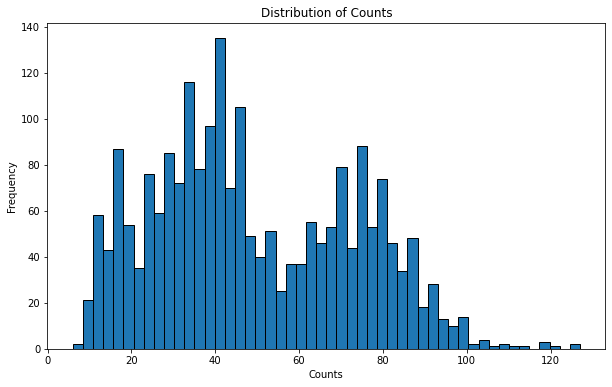

In [11]:
# 기본 통계 요약
print(datewise_counts.describe())

# 히스토그램
plt.figure(figsize=(10, 6))
datewise_counts.hist(bins=50, edgecolor='black')
plt.title("Distribution of Counts")
plt.xlabel("Counts")
plt.ylabel("Frequency")
plt.grid(False)
plt.show()

In [116]:
data_first_half.to_csv('eng_part1.csv', encoding='utf-8-sig', index=False)